In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from sklearn import linear_model
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy import io as sio 
import time



GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'


num GPUs 0


# 1. Load an test image from a dataset (now : CelebA 128x128)

Dimensions of input image: (3, 64, 64)


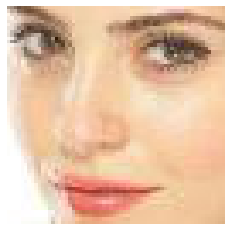

In [2]:
#dataset = 'mnist' # 'mnist' or 'celeba'
dataset = 'celeba'
path = './test_data/' + dataset + '/' 
img_name = dataset + '1' # 1-5 (for celeba), 1-6 (for mnist)
img_path = path + img_name + ".jpg"
img_pil = Image.open(img_path)
if dataset == 'celeba':
    img_pil = img_pil.crop((60,80+20,60+64,80+84)) #crop to 3 x 64 x 64
img_np = pil_to_np(img_pil)
print('Dimensions of input image:', img_np.shape)
img_np = img_np / np.max(img_np)
img_np_orig = 1*img_np

if dataset == 'celeba':
    plt.imshow(img_np.transpose(1,2,0))
else:
    plt.imshow(img_np[0,:,:])
    plt.gray()
plt.axis('off')
img_var = np_to_var(img_np).type(dtype)
d = img_np.shape[1]
out_ch = img_np.shape[0]
d_image = img_np.size

G0 = img_var

# 2. Compressed sensing using generative models

## 2.1. Load a pretrained generative model on the dataset (now: PGGAN)

In [ ]:
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)
G = model.netG
mse = torch.nn.MSELoss()

## 2.2. A=I

In [ ]:
#G0 = G(torch.zeros(1,model.config.noiseVectorDim))

def exp_lr_scheduler(optimizer, epoch, init_lr=0.05, lr_decay_epoch=100, factor=0.7):
    """Decay learning rate by a factor of 0.5 every lr_decay_epoch epochs."""
    lr = init_lr * (factor**(epoch // lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        print('\nLR is set to {}'.format(lr))
        print('\n')
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def fit(G, num_iter = 2000, lr_decay_epoch = 200):
    z = Variable(torch.randn(1,model.config.noiseVectorDim), requires_grad = True)
    optimizer = optim.Adam([z])
    for i in range(num_iter):
        #################
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.1, lr_decay_epoch=lr_decay_epoch, factor=0.8)
            
        #################
        def closure():
            optimizer.zero_grad()           
            x = G(z)
            loss = mse(x, G0)
            loss.backward(retain_graph=True)
            if i % 10 == 0:
                print('loss = {}'.format(loss))
            return loss

        loss = optimizer.step(closure)
    print('done')
    print('loss = {}'.format(loss))
    #print(z)
    return z

In [ ]:
z_hat = fit(G = G, num_iter = 500, lr_decay_epoch = 100)    
    
gen_image = G(z_hat)



grid = torchvision.utils.make_grid(gen_image.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

#print(gen_image-G0)

## 2.3. A= Gaussian 

In [ ]:
d_image = G0.numel()

f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)


# random Gaussian measurement matrix : A

A = torch.randn(m_image, d_image)
x = G0.reshape(d_image)
y = torch.matmul(A,x)
latentDim = model.config.noiseVectorDim

def fit2(G,A,y, d_image, latentDim, num_iter = 2000, lr_decay_epoch = 200):
    z = Variable(torch.randn(1,latentDim), requires_grad = True)
    
    optimizer = optim.Adam([z])
    for i in range(num_iter):
        ############
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.1, lr_decay_epoch = lr_decay_epoch, factor = 0.7)
        ############
        
        def closure():
            optimizer.zero_grad()
            
            x_var = G(z).reshape(d_image)
            y_var = torch.matmul(A,x_var)
            loss = mse(y_var, y)
            
            loss.backward(retain_graph = True)
            if i % lr_decay_epoch == 0:
                print('loss = {}'.format(loss))
            return loss
        
        loss = optimizer.step(closure)
    return z



In [ ]:
z = fit2(G, A, y, num_iter = 2000, lr_decay_epoch = 200)
x_hat = G(z)

#x_hat.reshape(x.size(0),x.size(1))
grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

# 4. Compressed Sensing using Deep decoder

## 4.1. Define the network

In [3]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample


if dataset == 'mnist':
    num_channels = [25,15,10] 
elif dataset== 'celeba':    
    num_channels = [120,30,20,10] 
else:
    num_channels = [128,64,32]
    
output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, 
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)



n_scales= 4 num_channels_up= [120, 30, 20, 10]
number of parameters:  9710
Sequential(
  (dconv0): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(120, 30, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu0): ReLU()
  (dbn0): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups0): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(30, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups1): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(20, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu2): ReLU()
  (dbn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups2): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv3): 

In [4]:
if decodetype=='upsample':
    p = [x for x in net.decoder.parameters() ] #list of all weigths
elif decodetype=='transposeconv':
    p = [x for x in net.convdecoder.parameters() ] #list of all weigths

weight_decay = 0
optimizer = torch.optim.Adam(p, lr=0.001 ,weight_decay=weight_decay)

## 4.2. A=I using untrained network

In [5]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=500, factor=0.5):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (factor**(epoch // lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        print('\nLearning rate is set to {}'.format(lr))
        print('\n')
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def fit3(net, num_channels, d_image, y, A, num_iter = 100, lr_decay_epoch = 50):
    # compute the size of (fixed) latent vector and draw it uniformly  
    totalupsample = 2**(len(num_channels)-1)
    w = np.sqrt(int(d_image/3)) # =d_image / out_channels = số chiều của mỗi cạnh ảnh
    width = int(w/(totalupsample))
    height = int(w/(totalupsample))

    shape = [1,num_channels[0], width, height]  
    print("shape of latent code B1: ", shape)

    print("initializing latent code B1...")
    net_input = Variable(torch.zeros(shape))
    net_input.data.uniform_()
    net_input.data *= 1./10

    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()

    #x_in = net(net_input.type(dtype)).data.clone() #initializing image

    mse = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(p, lr=0.001 ,weight_decay=weight_decay)
    
    for i in range(num_iter):

        #################
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.0001, lr_decay_epoch=lr_decay_epoch,factor=0.8)

        #################
        def closure():
            optimizer.zero_grad()           
            x_hat = net(net_input.type(dtype))
            
            y_hat = torch.matmul(A,x_hat.reshape(d_image))
            loss = mse(y_hat, y) #torch.matmul(A,x_hat)
            loss.backward()
            #mse_wrt_truth[i] = loss.data.cpu().numpy()
            return loss

        loss = optimizer.step(closure) 

        print ('Iteration %05d   Train loss %f ' % (i, loss.detach().cpu().numpy()), '\r', end='')

    return net, net_input, loss

In [7]:
f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)


A = torch.randn(m_image, d_image)
x = img_var.reshape(d_image)
y = torch.matmul(A,x)
print(y.shape)

Compression rate is  0.2
Number of measurements is  2457  for signal of length  12288
torch.Size([2457])


shape of latent code B1:  [1, 120, 8, 8]
initializing latent code B1...


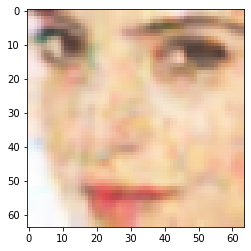

In [8]:
net, net_input, loss = fit3(net, num_channels, d_image, y=y, A = A, num_iter = 2000, lr_decay_epoch=0)
x_hat = net( net_input.type(dtype) ).data.cpu().numpy()[0]

plt.imshow(x_hat.transpose(1,2,0))
plt.show()

## 4.3. A=Gaussian using untrained network

# 5. Compressed sensing using hybrid model

In [ ]:
## 5.1. Define hybrid model